# German Credit Risk
_Dataset Link: https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

**Abstract**: This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

The dataset was used as part of the Statlog project, a European-based initiative in the 1990s to evaluate and compare a large number (at the time) of machine learning algorithms on a range of different classification tasks. The dataset is credited to Hans Hofmann.

The dataset includes 1,000 examples and 20 input variables, 7 of which are numerical (integer) and 13 are categorical.

* Status of existing checking account
* Duration in month
* Credit history
* Purpose
* Credit amount
* Savings account
* Present employment since
* Installment rate in percentage of disposable income
* Personal status and sex
* Other debtors
* Present residence since
* Property
* Age in years
* Other installment plans
* Housing
* Number of existing credits at this bank
* Job
* Number of dependents
* Telephone
* Foreign worker

This notebook will focus on developing the classification model witouth EDA or Feature Engineering which are good practices, but in this case I am just interested in working with an imbalanced dataset model devoloping.


In [1]:
# Libraries that were used in the model developing
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import RidgeClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score


In [2]:
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    dataframe = read_csv(full_path, header=None)
    # split into inputs and outputs
    last_ix = len(dataframe.columns) - 1
    
    stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_set, test_set in stratified.split(dataframe, dataframe[last_ix]):
        stratified_train = dataframe.loc[train_set]
        stratified_test = dataframe.loc[test_set]

    X, y = stratified_train.drop(last_ix, axis=1), stratified_train[last_ix]
    X_test, y_test = stratified_test.drop(last_ix, axis=1), stratified_test[last_ix]
    
    # select categorical and numerical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    y_test = LabelEncoder().fit_transform(y_test)
    
    return X.values, y, cat_ix, num_ix, X_test.values, y_test

In [3]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [4]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [5]:
# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('LR')
    # LDA
    models.append(RandomForestClassifier(class_weight='balanced'))
    names.append('RFC')
    # BRFC
    models.append(BalancedRandomForestClassifier(class_weight='balanced'))
    names.append('BRFC')
    # LGBMC
    models.append(LGBMClassifier(class_weight='balanced'))
    names.append('LGBMC')
    # RC
    models.append(RidgeClassifier(class_weight='balanced'))
    names.append('RC')
    return models, names

In [6]:
# define the location of the dataset
full_path = 'DATA/german.csv'
# load the dataset
X, y, cat_ix, num_ix, X_test, y_test = load_dataset(full_path)

In [7]:
models, names = get_models()
results = list()

for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('t',ct), ('m',models[i])])
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LR 0.631 (0.064)
>RFC 0.385 (0.085)
>BRFC 0.630 (0.070)
>LGBMC 0.546 (0.064)
>RC 0.632 (0.059)


In [8]:
model = BalancedRandomForestClassifier(class_weight='balanced')
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
pipeline = Pipeline(steps=[('t',ct), ('m',model)])

In [9]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# evaluate model
y_train_pred = cross_val_predict(pipeline, X, y, cv=cv)

In [10]:
confusion_matrix(y, y_train_pred)

array([[411, 149],
       [ 86, 154]], dtype=int64)

In [11]:
precision_score(y, y_train_pred) # == 1 / (1 + 0)

0.5082508250825083

In [12]:
recall_score(y, y_train_pred) # == 1 / (1 + 1225)

0.6416666666666667

In [13]:
f1_score(y, y_train_pred)

0.567219152854512

In [14]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# evaluate model
y_scores = cross_val_predict(pipeline, X, y, cv=cv,method="predict_proba")

In [15]:
y_scores_model = y_scores[:, 1] 

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_model)

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    pyplot.plot(thresholds, precisions[:-1], "b--", label="Precision")
    pyplot.plot(thresholds, recalls[:-1], "g-", label="Recall")
    pyplot.legend(loc="best", fontsize=16) 
    pyplot.xlabel("Threshold", fontsize=16)

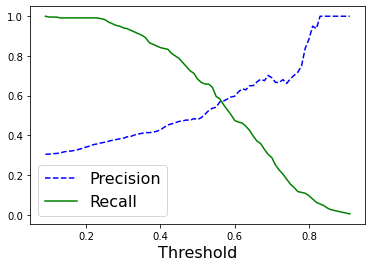

In [18]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
pyplot.show()

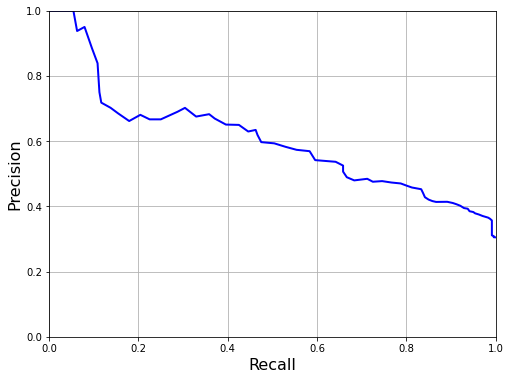

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    pyplot.plot(recalls, precisions, "b-", linewidth=2)
    pyplot.xlabel("Recall", fontsize=16)
    pyplot.ylabel("Precision", fontsize=16)
    pyplot.axis([0, 1, 0, 1])
    pyplot.grid(True)

pyplot.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
pyplot.show()

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
X_prepared = ct.fit_transform(X)

In [22]:
parameters = {'n_estimators': [10, 100, 500], 
              'max_features': ['log2', 'sqrt','auto'],
              'criterion': ['entropy', 'gini'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8] }

model = BalancedRandomForestClassifier(class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
metric = make_scorer(f2_measure)

rand_search = RandomizedSearchCV(model, parameters, cv=cv, scoring=metric, return_train_score=True)
rand_search.fit(X_prepared, y)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=BalancedRandomForestClassifier(class_weight='balanced'),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [1, 5, 8],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [10, 100, 500]},
                   return_train_score=True, scoring=make_scorer(f2_measure))

In [23]:
rand_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'entropy'}

In [24]:
final_model = rand_search.best_estimator_

In [25]:
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
pipeline = Pipeline(steps=[('t',ct), ('m',final_model)])

In [26]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# evaluate model
y_train_pred = cross_val_predict(pipeline, X, y, cv=cv)

In [27]:
confusion_matrix(y, y_train_pred)

array([[242, 318],
       [ 23, 217]], dtype=int64)

In [28]:
precision_score(y, y_train_pred) # == 1 / (1 + 0)

0.405607476635514

In [29]:
recall_score(y, y_train_pred) # == 1 / (1 + 1225)

0.9041666666666667

In [30]:
f1_score(y, y_train_pred)

0.5599999999999999

In [31]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# evaluate model
y_scores = cross_val_predict(pipeline, X, y, cv=cv,method="predict_proba")

In [32]:
y_scores_model = y_scores[:, 1] 

In [33]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores_model)

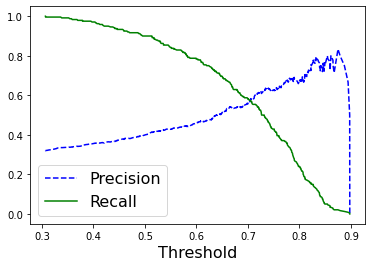

In [34]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
pyplot.show()

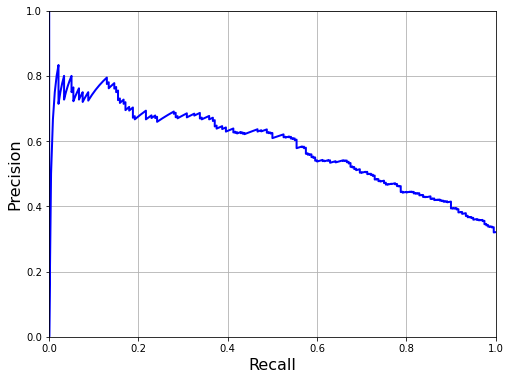

In [35]:
pyplot.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
pyplot.show()

In [36]:
X_prepared = ct.fit_transform(X)

In [37]:
rand_search.fit(X_prepared, y)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=BalancedRandomForestClassifier(class_weight='balanced'),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [1, 5, 8],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [10, 100, 500]},
                   return_train_score=True, scoring=make_scorer(f2_measure))

In [38]:
X_test_prepared = ct.transform(X_test)

In [41]:
final_predictions = final_model.predict(X_test_prepared)

In [42]:
import seaborn as sns

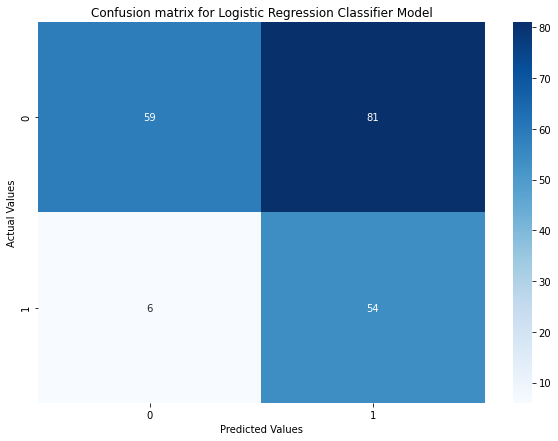

In [43]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
pyplot.figure(figsize=(10,7))
p = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
pyplot.title('Confusion matrix for Logistic Regression Classifier Model')
pyplot.xlabel('Predicted Values')
pyplot.ylabel('Actual Values')
pyplot.show()

In [44]:
from sklearn.metrics import classification_report

In [45]:
# Evaluate predictions
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.91      0.42      0.58       140
           1       0.40      0.90      0.55        60

    accuracy                           0.56       200
   macro avg       0.65      0.66      0.56       200
weighted avg       0.76      0.56      0.57       200



This model is very good recognazing the good loans so as it could work as a first filter to give the credits and there go into further study of the loans that marked as bad ones